In [18]:
import matplotlib.pyplot as plt
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras import utils
from keras import layers

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.13.1


In [2]:
# import data
raw_data =  pd.read_csv('../raw-data/skills_test.csv')

In [3]:
def clean_text(s):
    """
    Pre-process text data by removing stop words, puncuation and strange characters
    
    return string
    """
    symbols_re = re.compile('[^a-z #+_]')
    space_re = re.compile('[/(){}\[\]\|@,;]')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = s.lower()
    s = symbols_re.sub('', s)
    s = space_re.sub(' ', s)
    s = ' '.join([l for l in s.split() if l not in stopwords.words('english')])
    return s

In [13]:
# logger.info('cleaning text, this may take 1-2 minutes...')
raw_data['Text'] = raw_data['Text'].apply(clean_text)

In [14]:
x = raw_data['Text']
y = raw_data['label']
text_train, text_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [15]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [16]:
tokenize.fit_on_texts(text_train) # only fit on train
x_train = tokenize.texts_to_sequences(text_train)
x_test = tokenize.texts_to_sequences(text_test)

In [21]:
vocab_size = len(tokenize.word_index) + 1  # Adding 1 because of reserved 0 index

In [24]:
 maxlen = 100
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [43]:
x_test

array([[  1,  35,   3, ...,   0,   0,   0],
       [ 32,   1,   2, ...,   0,   0,   0],
       [698, 141, 264, ...,   0,   0,   0],
       ...,
       [ 40, 248,  63, ...,   0,   0,   0],
       [587, 411,   1, ...,   0,   0,   0],
       [143,  14, 238, ...,   0,   0,   0]], dtype=int32)

In [25]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [26]:
# Build the model
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           729250    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 779,271
Trainable params: 779,271
Non-trainable params: 0
_________________________________________________________________


In [27]:

# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 2411 samples, validate on 268 samples
Epoch 1/2
2411/2411 [==============================] - 7s 3ms/step - loss: 0.5574 - acc: 0.7225 - val_loss: 0.4604 - val_acc: 0.7985
Epoch 2/2
2411/2411 [==============================] - 5s 2ms/step - loss: 0.3741 - acc: 0.8470 - val_loss: 0.2879 - val_acc: 0.8843


In [28]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

1149/1149 [==============================] - 0s 223us/step
Test score: 0.36757227093681655
Test accuracy: 0.8346388164658044


In [35]:
history = model.fit(x_train, y_train,
                    epochs=2,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.9025


In [41]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

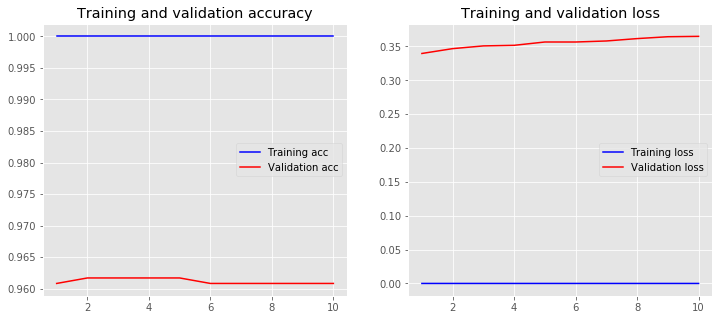

In [42]:
plot_history(history)

In [38]:
# Build the model
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           729250    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 729,771
Trainable params: 729,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9608


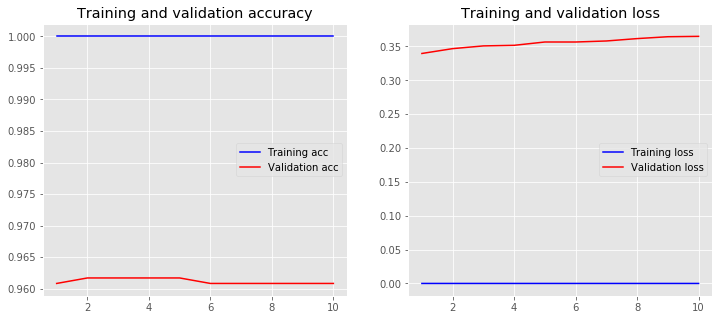

In [40]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)